In [1]:
import pandas as pd
import numpy as np
import cv2
import itertools


from cycling_manager.preprocess import split, get_data, preprocess

from cycling_manager.sequences import get_sequences, get_sequence, get_scaler

from cycling_manager.main import get_seq

from tensorflow.keras.layers import TimeDistributed, LSTM, Dense, Input, Conv2D, Flatten, MaxPooling2D, Masking, LayerNormalization, RepeatVector, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling


from tensorflow.keras import Model



import tensorflow as tf

In [2]:
df = preprocess(get_data())

full df shape (603619, 25)
full df shape (603619, 25)
Score vertical meters - model: DecisionTreeRegressor() score: 0.9995694705426378
Score vertical meters - model: DecisionTreeRegressor() score: 0.9999262004447953
Score vertical meters - model: KNeighborsClassifier() score: 0.9942287567477957


In [3]:
train, test = split(df, start=2020, end=2022)

In [4]:
df.columns

Index(['name', 'year', 'type', 'date', 'result', 'gc', 'icon', 'race_ref',
       'race_name', 'race_detail', 'race_rank', 'distance', 'points',
       'Avg. speed winner:', 'Distance:', 'Parcours type:', 'ProfileScore:',
       'Vert. meters:', 'Startlist quality score:', 'Won how: ',
       'adjusted_points', 'Race category:', 'Points scale:', 'Arrival:',
       'Won how:', 'parcours_type_num', 'gt_binary', 'key', 'result_bin',
       'types_bin', 'icon_bin'],
      dtype='object')

In [5]:
train.year.unique()

array([2021, 2020])

In [6]:
y_dec_ls = []
tour_ls = []
season_ls = []
result_ls = []

for name, year, tour in train.values:
    y_decoder, tour_data, result, season_data = get_sequence(df, name, year, tour, img=True, binary=False, maxlen=30)
    y_dec_ls.append(y_decoder)
    tour_ls.append(tour_data)
    result_ls.append(result)
    season_ls.append(season_data)


 dropped nan for ('francesco-gavazzi', 2021, 'giro-d-italia')

 dropped nan for ('manuel-belletti', 2021, 'giro-d-italia')

 dropped nan for ('krists-neilands', 2021, 'giro-d-italia')

 dropped nan for ('jacopo-mosca', 2021, 'giro-d-italia')

 dropped nan for ('krists-neilands', 2020, 'tour-de-france')

 dropped nan for ('jacopo-mosca', 2020, 'giro-d-italia')

 dropped nan for ('marco-frapporti', 2020, 'giro-d-italia')


In [7]:
season_ls_img = []
to_drop_ls = []

for season in season_ls:
    base_path = '../raw_data/img_300/'
    season = [base_path+"_".join(race.split('/')[1:])+'.jpg' for race in season]
    
    img_ls = []
    
    for race in season:
        img = cv2.imread(race)
        try:
            img = tf.convert_to_tensor(img)
            img_ls.append(img)
        except:
            to_drop_ls.append('race/'+race.split('/')[-1].split('.')[0].replace('_', '/'))
        
    season_ls_img.append(np.array(img_ls))
    
season_ls_img = np.array(season_ls_img)
to_drop_ls = list(dict.fromkeys(to_drop_ls))
    

[ WARN:0@71.803] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../raw_data/img_300/danish-championships_2021_result.jpg'): can't open/read file: check file path/integrity
[ WARN:0@71.943] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../raw_data/img_300/nc-belgium_2020_result.jpg'): can't open/read file: check file path/integrity
[ WARN:0@72.169] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../raw_data/img_300/nc-switserland_2020_result.jpg'): can't open/read file: check file path/integrity
[ WARN:0@72.276] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('../raw_data/img_300/nc-netherlands_2020_result.jpg'): ca

In [8]:
tour_ls_img = []

for season in tour_ls:
    base_path = '../raw_data/img_300/'
    season = [base_path+"_".join(race.split('/')[1:])+'.jpg' for race in season]
    
    img_ls = []
    
    for race in season:
        img = cv2.imread(race)
        try:
            img = tf.convert_to_tensor(img)
            img_ls.append(img)
        except:
            print(race)
        
    tour_ls_img.append(np.array(img_ls))
    
tour_ls_img = np.array(tour_ls_img)

/var/folders/3l/70h6qcrd72q0j5x4sscw7qn40000gn/T/ipykernel_8504/764442808.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tour_ls_img = np.array(tour_ls_img)


In [9]:
result_ls_2 = [list(itertools.chain(*x[~x.race_ref.isin(to_drop_ls)].drop(columns='race_ref').values)) for x in result_ls]


In [10]:
y_dec_ls_2 = [list(itertools.chain(*x.values)) for x in y_dec_ls]



In [11]:
df_2 = df[~df.race_ref.isin(to_drop_ls)]

In [12]:
def get_sequences_img(season_ls, result_ls):
    new_season_ls = []
    new_result_ls = []
    
    for season, results in zip(season_ls, result_ls):
        if season.shape[0] == 0:
            pass
        else:
            print(season.shape)
            tensors_season = tf.convert_to_tensor(season, dtype=tf.float32)
            new_season_ls.append(tensors_season)
            
            tensors_y = tf.convert_to_tensor(results, dtype=tf.float32)
            new_result_ls.append(tensors_y)
        
    X_encoder_train = tf.ragged.stack(new_season_ls).to_tensor()
    y_encoder_train = tf.ragged.stack(new_result_ls).to_tensor()
    
    return X_encoder_train, y_encoder_train

In [13]:
X_encoder_img_train, y_encoder_img_train = get_sequences_img(season_ls_img, result_ls_2)

X_encoder_img_train.shape, y_encoder_img_train.shape

(29, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(28, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(24, 150, 300, 3)
(23, 150, 300, 3)
(30, 150, 300, 3)
(20, 150, 300, 3)
(19, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(29, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(23, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(17, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(21, 150, 300, 3)
(9, 150, 300, 3)
(4, 150, 300, 3)
(17, 150, 300, 3)
(15, 150, 300, 3)
(13, 150, 300, 3)
(18, 150, 300, 3)
(29, 150, 300, 3)
(11, 150, 300, 3)
(30, 150, 300, 3)
(30, 150, 300, 3)
(16, 150, 300, 3)
(21, 150, 300, 3)
(15, 150, 300, 3)
(30, 150, 300, 3)
(10, 150, 300, 3)
(30, 150, 300, 3)
(14, 150, 30

(TensorShape([942, 30, 150, 300, 3]), TensorShape([942, 30]))

In [14]:
X_decoder_img_train, y_decoder_img_train = get_sequences_img(tour_ls_img, y_dec_ls_2)

X_decoder_img_train.shape, y_decoder_img_train.shape

(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 300, 3)
(21, 150, 

(TensorShape([944, 21, 150, 300, 3]), TensorShape([944, 21]))

In [15]:
X_encoder_train, X_decoder_train, y_decoder_train = get_seq(train, df_2, 30)


 dropped nan for ('francesco-gavazzi', 2021, 'giro-d-italia')

 dropped nan for ('manuel-belletti', 2021, 'giro-d-italia')

 dropped nan for ('krists-neilands', 2021, 'giro-d-italia')

 dropped nan for ('jacopo-mosca', 2021, 'giro-d-italia')

 dropped nan for ('krists-neilands', 2020, 'tour-de-france')

 dropped nan for ('jacopo-mosca', 2020, 'giro-d-italia')

 dropped nan for ('marco-frapporti', 2020, 'giro-d-italia')
\Scaler done...

 Getting sequence for ('magnus-cort-nielsen', 2021, 'tour-de-france')

 Getting sequence for ('maciej-bodnar', 2021, 'giro-d-italia')

 Getting sequence for ('jan-tratnik', 2021, 'giro-d-italia')

 Getting sequence for ('rafael-valls', 2021, 'giro-d-italia')

 Getting sequence for ('giovanni-visconti', 2021, 'giro-d-italia')

 Getting sequence for ('enrico-battaglin', 2021, 'giro-d-italia')

 Getting sequence for ('giovanni-carboni', 2021, 'giro-d-italia')

 Getting sequence for ('filippo-fiorelli', 2021, 'giro-d-italia')

 Getting sequence for ('davide

In [16]:
model = Sequential()
# define CNN model
model.add(TimeDistributed(Rescaling(1./255, input_shape=(150,300,3))))

model.add(TimeDistributed(Conv2D(16, kernel_size=10, activation='relu')))
model.add(TimeDistributed(MaxPooling2D(3)))

model.add(TimeDistributed(Conv2D(32, kernel_size=6, activation="relu")))
model.add(TimeDistributed(MaxPooling2D(3)))

model.add(TimeDistributed(Flatten()))

model.add(TimeDistributed(Dense(100, activation='relu')))

model.add(TimeDistributed(Dense(30, activation='relu')))

# define LSTM model
model.add(LSTM(units=15, dropout=0.2, return_sequences=True, activation='tanh'))
model.add(Dense(units=1, activation='linear'))

In [ ]:
initial_learning_rate = 0.01

lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.5)

adam = Adam(learning_rate=lr_schedule)

    
model.compile(optimizer=adam, loss='mean_absolute_error', metrics='mean_absolute_error')

batch_size=8
patience=3
validation_split=0.3

es = EarlyStopping(monitor="val_loss",
                       patience=patience,
                       restore_best_weights=True,
                       verbose=0)

history = model.fit(X_encoder_img_train, y_encoder_img_train,
                        validation_split=validation_split,
                        epochs=1000,
                        batch_size=batch_size,
                        callbacks=[es],
                        verbose=1)

In [17]:
from tensorflow.keras.applications.resnet50 import ResNet50

def load_model(train=False):
    
    # $CHALLENGIFY_BEGIN
    
    model = ResNet50(weights="imagenet", include_top=False, input_shape=X_decoder_img_train.shape[2:])
    
    if train == False:
        model.trainable = False
    
    # $CHALLENGIFY_END
    
    return model

In [20]:
resnet = load_model(train=False)

In [21]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 306, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 150, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 150, 64)  256         ['conv1_conv[0][0]']      

In [22]:
def encoder_image(images):
    x = TimeDistributed(Rescaling(1./255, input_shape=(150,300,3)))(images)
    # x = TimeDistributed(Conv2D(16, kernel_size=10, activation='relu'))(x)
    # x = TimeDistributed(MaxPooling2D(3))(x)
    # x = TimeDistributed(Conv2D(32, kernel_size=10, activation='relu'))(x)
    # x = TimeDistributed(MaxPooling2D(3))(x)
    # x = TimeDistributed(Conv2D(16, kernel_size=8, activation='relu'))(x)
    # x = TimeDistributed(MaxPooling2D(3))(x)
    
    x = TimeDistributed(resnet)(x)
    x = TimeDistributed(Flatten())(x)
    x = TimeDistributed(Dense(100, activation='relu'))(x)
    x = TimeDistributed(Dense(30, activation='relu'))(x)
    
    return x
    

In [23]:
def decoder_image(images):
    x = TimeDistributed(Rescaling(1./255, input_shape=(150,300,3)))(images)
    # x = TimeDistributed(Conv2D(16, kernel_size=10, activation='relu'))(x)
    # x = TimeDistributed(MaxPooling2D(3))(x)
    # x = TimeDistributed(Conv2D(32, kernel_size=10, activation='relu'))(x)
    # x = TimeDistributed(MaxPooling2D(3))(x)
    # x = TimeDistributed(Conv2D(16, kernel_size=8, activation='relu'))(x)
    # x = TimeDistributed(MaxPooling2D(3))(x)
    
    x = TimeDistributed(resnet)(x)
    x = TimeDistributed(Flatten())(x)
    x = TimeDistributed(Dense(100, activation='relu'))(x)
    x = TimeDistributed(Dense(30, activation='relu'))(x)
    
    return x

In [24]:
def encoder(encoder_features, encoder_image_features):
    y = Masking(mask_value = -1000.)(encoder_features)
    
    y = Concatenate(axis=-1)([y, encoder_image_features])
    
    #each LSTM unit returning a sequence of 6 outputs, one for each time step in the input data
    y = LSTM(units=15, dropout=0.2, return_sequences=True, activation='tanh')(y)
    y = LayerNormalization()(y)
    y = LSTM(units=30, dropout=0.2, return_sequences=True, activation='tanh')(y)
    y = LayerNormalization()(y)
    #output one time step from the sequence for each time step in the input but process 5 outputs of the input sequence at a time
    #y = TimeDistributed(Dense(units=5, activation='tanh'))(y)
    y = LSTM(units=6, dropout=0.2, return_sequences=False, activation='tanh')(y)
    y = RepeatVector(21)(y)
    return y

In [25]:
def decoder(decoder_features, encoder_outputs, decoder_image_features):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs, decoder_image_features])
    # x = Add()([decoder_features, encoder_outputs]) 
    x = Masking(mask_value = -1000.)(x)
    x = TimeDistributed(Dense(units=32, activation='relu'))(x)
    x = TimeDistributed(Dense(units=16, activation='relu'))(x)
    x = TimeDistributed(Dense(units=6, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1, activation='linear'))(x)
    return y

def combine_model(X_encoder, X_decoder, img_encoder, img_decoder):
    
    # define input shapes
    encoder_features = Input(shape=X_encoder.shape[1:])
    decoder_features = Input(shape=X_decoder.shape[1:])
    encoder_img_features = Input(shape=img_encoder.shape[1:])
    decoder_img_features = Input(shape=img_decoder.shape[1:])
    
    #get cnn output for encoder/decoder
    encoder_img_output = encoder_image(encoder_img_features)
    decoder_img_output = decoder_image(decoder_img_features)
        
    #set encoder
    encoder_outputs = encoder(encoder_features, encoder_img_output)
    
    #set dedocer
    decoder_outputs = decoder(decoder_features, encoder_outputs, decoder_img_output)
    
    #set model
    model = Model([encoder_features, decoder_features, encoder_img_features, decoder_img_features], decoder_outputs)
    
    #print(Fore.YELLOW + f"\nCombined model..." + Style.RESET_ALL)
    
    return model

def compile_model(model):
    
    initial_learning_rate = 0.01

    lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.5)

    adam = Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=adam, loss='mean_absolute_error', metrics='mean_absolute_error')
    
    #print(Fore.YELLOW + f"\Compile model..." + Style.RESET_ALL)

    return model

In [26]:
model = combine_model(X_encoder_train, X_decoder_train, X_encoder_img_train, X_decoder_img_train)

In [27]:
model = compile_model(model)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 30, 150, 30  0           []                               
                                0, 3)]                                                            
                                                                                                  
 time_distributed (TimeDistribu  (None, 30, 150, 300  0          ['input_5[0][0]']                
 ted)                           , 3)                                                              
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 30, 5, 10, 2  23587712   ['time_distributed[0][0]']       
 buted)                         048)                                                          

In [39]:
import tensorflow as tf
tf.keras.utils.plot_model(model, "multi_input_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
def train_model(model: Model,
                x_encoder: np.ndarray,
                x_decoder: np.ndarray,
                x_encoder_img,
                x_decoder_img,
                y: np.ndarray,
                batch_size=128,
                patience=20,
                validation_split=0.3,
                validation_data=None):
    """
    Fit model and return a the tuple (fitted_model, history)
    """


    es = EarlyStopping(monitor="val_loss",
                       patience=patience,
                       restore_best_weights=True,
                       verbose=0)

    history = model.fit([x_encoder, x_decoder, x_encoder_img, x_decoder_img],
                        y,
                        validation_split=validation_split,
                        validation_data=validation_data,
                        epochs=1000,
                        batch_size=batch_size,
                        callbacks=[es],
                        verbose=1)


    return model, history

In [30]:
X_encoder_train.shape, X_decoder_train.shape, X_encoder_img_train.shape, X_decoder_img_train.shape, y_decoder_train.shape

((942, 30, 15),
 (942, 21, 5),
 TensorShape([942, 30, 150, 300, 3]),
 TensorShape([944, 21, 150, 300, 3]),
 (942, 21, 1))

In [31]:
model, history = train_model(model, X_encoder_train, X_decoder_train, X_encoder_img_train, X_decoder_img_train, y_decoder_train,\
        batch_size=16, patience=5, validation_split=0.2, validation_data=None)

Epoch 1/1000


2023-01-08 12:44:17.100834: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [24]:
model.save('../models/cnn/40/')

INFO:tensorflow:Assets written to: ../models/cnn/40/assets


INFO:tensorflow:Assets written to: ../models/cnn/40/assets


In [21]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

In [22]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

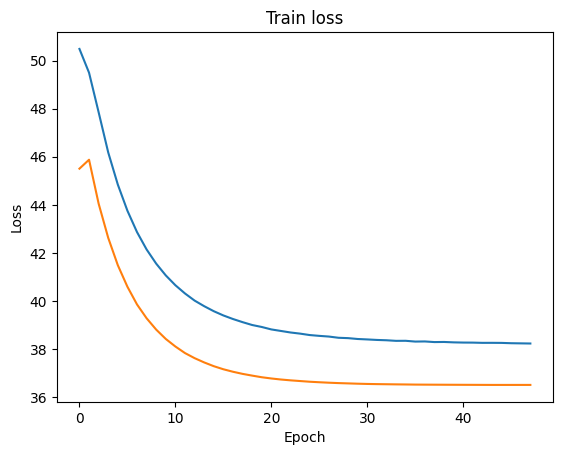

In [23]:
plot_history(history)